In [2]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import os
import cv2
import numpy as np
import easyocr
import nbimporter

In [3]:
from tensorflow.keras.models import load_model
from ocr_easy import EasyReceiptOCR
from text_clasification import transform_json
from text_clasification import predict_stage1_and_stage2
from text_clasification import extract_text_values



In [4]:
def clean_data(data):
    cleaned_data = []
    for item in data:
        for word in item.get('words', []):
            cleaned_data.append({
                'quad': word.get('quad'),
                'text': word.get('text')
            })
    return cleaned_data

[{'quad': {'x1': 226, 'y1': 451, 'x2': 369, 'y2': 451, 'x3': 369, 'y3': 499, 'x4': 226, 'y4': 499}, 'text': 'KOROKE'}, {'quad': {'x1': 385, 'y1': 461, 'x2': 453, 'y2': 461, 'x3': 453, 'y3': 497, 'x4': 385, 'y4': 497}, 'text': 'OR !'}, {'quad': {'x1': 228, 'y1': 491, 'x2': 367, 'y2': 491, 'x3': 367, 'y3': 535, 'x4': 228, 'y4': 535}, 'text': 'KOROKE'}, {'quad': {'x1': 385, 'y1': 497, 'x2': 501, 'y2': 497, 'x3': 501, 'y3': 535, 'x4': 385, 'y4': 535}, 'text': 'CURR ?'}, {'quad': {'x1': 471, 'y1': 533, 'x2': 547, 'y2': 533, 'x3': 547, 'y3': 575, 'x4': 471, 'y4': 575}, 'text': 'PCs'}, {'quad': {'x1': 191, 'y1': 617, 'x2': 211, 'y2': 617, 'x3': 211, 'y3': 645, 'x4': 191, 'y4': 645}, 'text': '3'}, {'quad': {'x1': 231, 'y1': 613, 'x2': 389, 'y2': 613, 'x3': 389, 'y3': 651, 'x4': 231, 'y4': 651}, 'text': 'TSUKUNE'}, {'quad': {'x1': 561, 'y1': 613, 'x2': 615, 'y2': 613, 'x3': 615, 'y3': 651, 'x4': 561, 'y4': 651}, 'text': '35'}, {'quad': {'x1': 227, 'y1': 649, 'x2': 326, 'y2': 649, 'x3': 326, 'y3

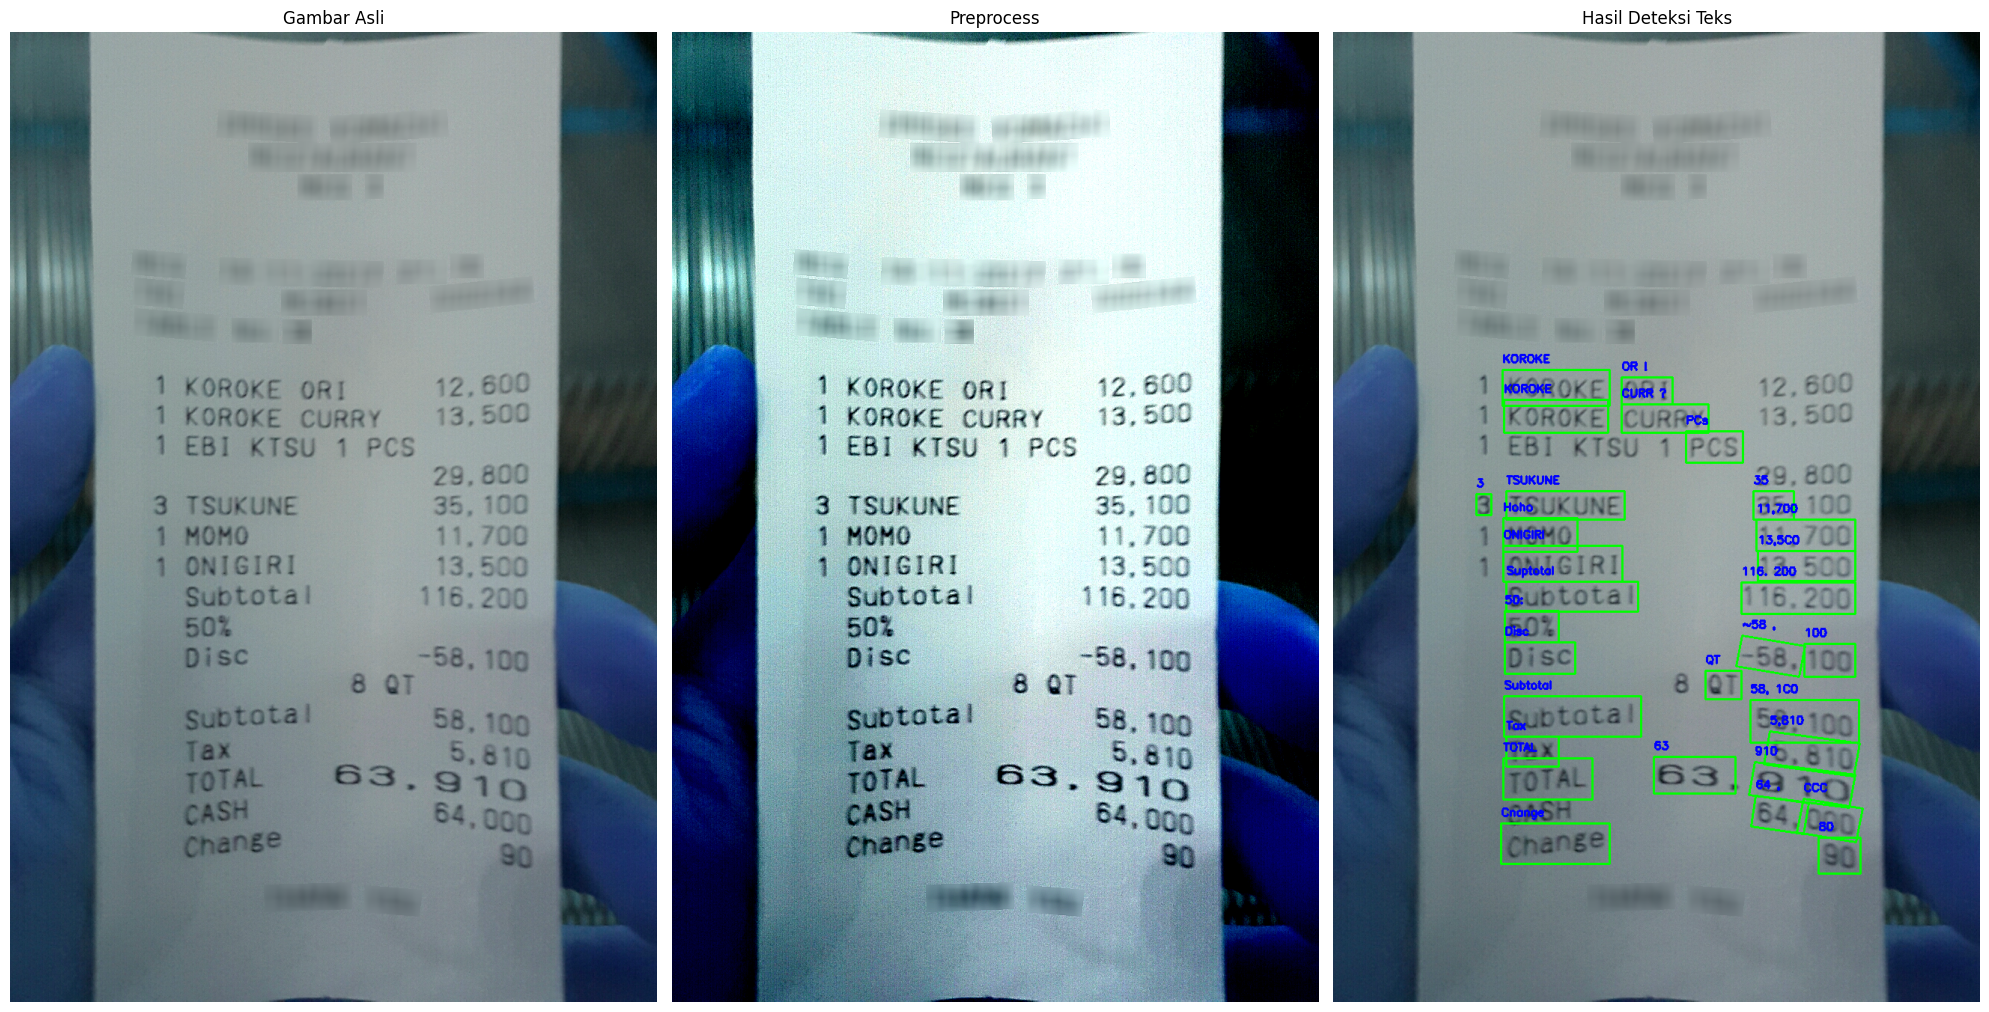

d:\Documents\Kuliah\Semester 5\Studi Independen\capstone\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_22', 'input_layer_23']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


d:\Documents\Kuliah\Semester 5\Studi Independen\capstone\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_24', 'input_layer_25']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Text: KOROKE, Label: other
Text: OR !, Label: other
Text: KOROKE, Label: other
Text: CURR ?, Label: other
Text: PCs, Label: other
Text: 3, Label: other
Text: TSUKUNE, Label: other
Text: 35, Label: other
Text: Hoho, Label: other
Text: 11,700, Label: other
Text: ONIGIRI, Label: other
Text: 13,5C0, Label: other
Text: Suptotal, Label: other
Text: 116. 200, Label: other
Text: 50:, Label: other
Text: Disc, Label: other
Text: 100, Label: other
Text: QT, Label: other
Text: Subtotal, Label: other
Text: 58, 1C0, Label: other
Text: Tax, Label: tax_text
Text: TOTAL, Label: total_text
Text: 63 , Label: tax_value
Text: Cnange, Label: other
Text: 80, Label: other
Text: ~58 ,, Label: other
Text: 5,810, Label: tax_value
Text: 910, Label: tax_value
Text: 64 ,, Label: other
Text: CCC, Label: other
{
    "total_value": 0,
    "tax_value": 910.0
}


In [11]:
def main():
    # Contoh penggunaan EasyReceiptOCR
    ocr = EasyReceiptOCR(['en', 'id'])  # Menambahkan bahasa yang diperlukan, misalnya ['en', 'id']
    
    # Path gambar yang akan diproses
    image_path = "D:/Documents/Kuliah/Semester 5/Studi Independen/capstone/output_images/image_1.png"
    
    # Membaca gambar
    image = Image.open(image_path)
    image_data = np.array(image)  # Convert to NumPy array

    # Ekstraksi teks dan lokasi
    easy_results, receipt_data, visualization_image = ocr.extract_text_and_location(image_data)

    # Membersihkan hasil ekstraksi data
    cleaned_result = clean_data(receipt_data)
    print(cleaned_result)  # Verifikasi bahwa cleaned_result sudah didefinisikan

    # Menampilkan hasil deteksi
    ocr.visualize_results(image_data, visualization_image)

    # Menyimpan hasil ekstraksi ke JSON (Jika perlu)
    # output_path = "receipt_output_easyocr.json"
    # ocr.save_to_json(receipt_data, output_path)

    # Ekstrak teks per baris
    text = ocr.extract_text_by_line(image_data)
    # print(text)

    # Setelah hasil ekstraksi data bersih, melanjutkan ke tahap prediksi
    # Setelah hasil ekstraksi data bersih, melanjutkan ke tahap prediksi
    if len(image_data.shape) == 3:  # If the image has 3 dimensions (e.g., RGB)
        image_height, image_width, _ = image_data.shape  # Ignore the channels dimension
    else:
        image_height, image_width = image_data.shape  # For grayscale images, only height and width
    image_size = {'width': image_width, 'height': image_height}


    from tensorflow.keras.models import load_model
    import pickle

    # Load the models
    model_stage1 = load_model("model_stage1.h5")
    model_stage2 = load_model("model_stage2.h5")  # Assuming a similar stage 2 model exists

    # Load tokenizers and label encoders
    with open("char_to_idx.pkl", "rb") as file:
        char_to_idx = pickle.load(file)

    with open("label_encoder_stage1.pkl", "rb") as file:
        label_encoder_stage1 = pickle.load(file)

    with open("label_encoder_stage2.pkl", "rb") as file:
        label_encoder_stage2 = pickle.load(file)

    # Prediksi menggunakan hasil yang sudah dibersihkan
    predicted_results = predict_stage1_and_stage2(
        input_data=cleaned_result,
        model_stage1=model_stage1,
        model_stage2=model_stage2,
        char_to_idx=char_to_idx,
        label_encoder_stage1=label_encoder_stage1,
        label_encoder_stage2=label_encoder_stage2,
        image_size=image_size
    )

    # Cetak hasil prediksi
    for result in predicted_results:
        # print(f"Text: {result['text']}, Stage 1 Label: {result['stage1_label']}, Stage 2 Label: {result['stage2_label']}")
        print(f"Text: {result['text']}, Label: {result['stage2_label']}")

    # Menggunakan fungsi untuk menghasilkan JSON
    result_json = extract_text_values(predicted_results)

    # Cetak hasil dalam format JSON
    import json
    print(json.dumps(result_json, indent=4))


if __name__ == "__main__":
    main()
